In [24]:
import pandas as pd
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt

import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')
sns.set_palette('rainbow')

Let's load a dataset and take a look at it.

In [55]:
NAME='nottem' # AirPassengers, nottem, nhtemp
df = data(NAME)
df[:5]

,time,nottem
1,1920.000000,40.6
2,1920.083333,40.8
3,1920.166667,44.4
4,1920.250000,46.7
5,1920.333333,54.1


Let's look at the decompostion of the series

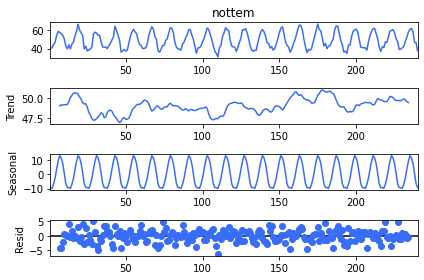

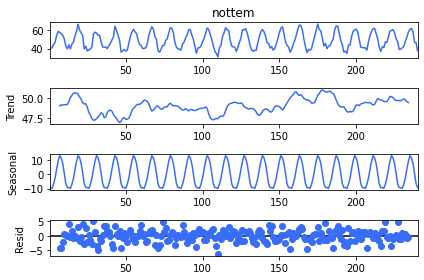

In [56]:
result = seasonal_decompose(df['nottem'], model='additive', period=12)
result.plot()

Now we can plot it, and look also at the Sliding Mean and Sliding STD.

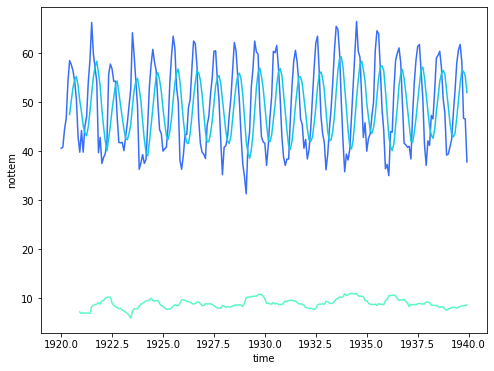

In [57]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='time',y=NAME)

rolling_mean = df[NAME].rolling(window = 6).mean()
plt.plot(df['time'],rolling_mean)

rolling_std = df.rolling(window = 12).std()
plt.plot(df['time'],rolling_std[NAME])

We may also observe, when dividing the data into yearly bins, about trends.

(31.3, 66.5)

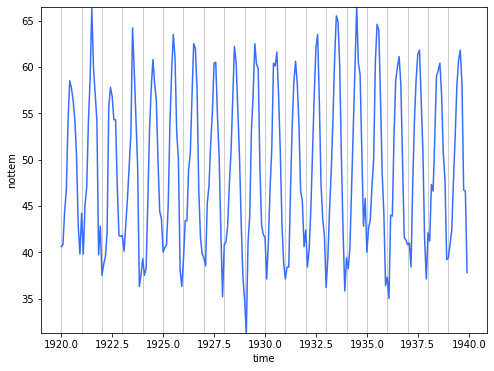

In [58]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df,x='time',y=NAME)
x = list(range(int(min(df['time'])),int(max(df['time'])+1)))
for _ in x:
    sns.lineplot(x=_,y=[min(df[NAME]),max(df[NAME])],lw=1,color='black')
plt.ylim(min(df[NAME]),max(df[NAME]))

Let's have a look at the autocorrelation of the time series.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

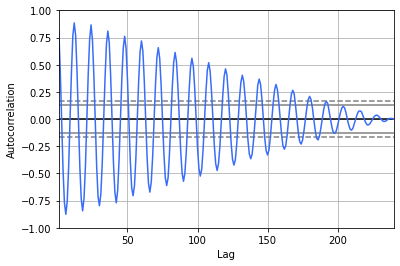

In [59]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df[NAME])

Now we run the ARIMA model

                               SARIMAX Results                                
Dep. Variable:                 nottem   No. Observations:                  240
Model:               ARIMA(12, 2, 12)   Log Likelihood                -560.538
Date:                Thu, 28 Oct 2021   AIC                           1171.076
Time:                        16:35:23   BIC                           1257.883
Sample:                             0   HQIC                          1206.060
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1761      0.163     -7.196      0.000      -1.496      -0.856
ar.L2         -1.2651      0.135     -9.362      0.000      -1.530      -1.000
ar.L3         -1.2519      0.129     -9.685      0.0

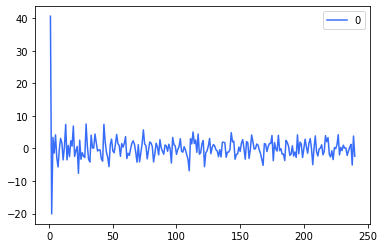

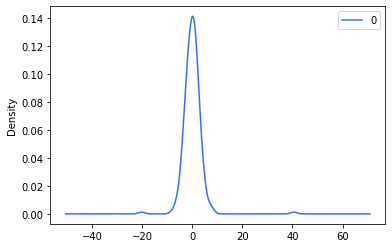

                0
count  240.000000
mean     0.110344
std      3.892904
min    -20.100485
25%     -1.730582
50%      0.037340
75%      1.595678
max     40.600000


In [60]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA

# fit model
model = ARIMA(df[NAME], order=(12,2,12))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [61]:
Y = df[NAME].values
split = int(len(Y) * 0.6)
_train = Y[:split]
test = Y[split:]
train = [x for x in _train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(train, order=(12,2,0))
	model_fit = model.fit()
	out = model_fit.forecast()
	predictions.append(out[0])
	obs = test[t]
	train.append(obs)
	print(f'TEST = {out[0]} - PRED = {obs}')
rmse = math.sqrt(mean_squared_error(df[NAME][split:], predictions))
print(f"RMSE: {rmse}")


TEST = 39.13403508176579 - PRED = 42.4
TEST = 42.763055086160904 - PRED = 38.4
TEST = 42.454801769403744 - PRED = 40.3
TEST = 45.96715796402583 - PRED = 44.6
TEST = 51.17136908396795 - PRED = 50.9
TEST = 55.62920681382263 - PRED = 57.0
TEST = 58.0332776910289 - PRED = 62.1
TEST = 60.10945861027476 - PRED = 63.5
TEST = 58.6365925430673 - PRED = 56.3
TEST = 52.687138033481226 - PRED = 47.3
TEST = 43.32758117219534 - PRED = 43.6
TEST = 40.7633726361213 - PRED = 41.8
TEST = 39.63081774167144 - PRED = 36.2
TEST = 37.136245486362775 - PRED = 39.3
TEST = 39.56115399907389 - PRED = 44.5
TEST = 48.25245661400928 - PRED = 48.7
TEST = 55.229910149500014 - PRED = 54.2
TEST = 60.40816077402909 - PRED = 60.8
TEST = 64.18252676508811 - PRED = 65.5
TEST = 64.79116047284903 - PRED = 64.9
TEST = 60.34873904228263 - PRED = 60.1
TEST = 53.0467298802151 - PRED = 50.2
TEST = 45.20434078775981 - PRED = 42.1
TEST = 38.79621071041595 - PRED = 35.8
TEST = 34.01279133894157 - PRED = 39.4
TEST = 39.68770440862646

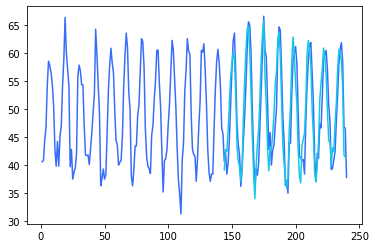

In [62]:
plt.plot(df[NAME])
plt.plot(range(split,len(Y)),predictions)

In [63]:
Y = df[NAME].values
split = int(len(Y) * 0.8)
_train = Y[:split]

df_result = pd.DataFrame()

for p in [0,1,2,3,4]:
    for d in [0,1,2]:
        for q in [0,1,2]:
            test = Y[split:len(Y)]
            train = [x for x in _train] 
            predictions = list()
            for t in range(len(test)):
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()
                out = model_fit.forecast()
                predictions.append(out[0])
                obs = test[t]
                train.append(obs)
            rmse = math.sqrt(mean_squared_error(df[NAME][split:], predictions))
            df_result = df_result.append({'p':int(p),'d':int(d),'q':int(q),'rmse':rmse}, ignore_index=True)
            print(f"ARIMA({p},{d},{q}) - RMSE = {rmse}")

ARIMA(0,0,0) - RMSE = 8.367438341661787
ARIMA(0,0,1) - RMSE = 5.757085465480193
ARIMA(0,0,2) - RMSE = 4.711831757294677
ARIMA(0,1,0) - RMSE = 5.143604443060009
ARIMA(0,1,1) - RMSE = 4.910403814962208
ARIMA(0,1,2) - RMSE = 4.42656471066216
ARIMA(0,2,0) - RMSE = 5.616271004859552
ARIMA(0,2,1) - RMSE = 5.195540033232998
ARIMA(0,2,2) - RMSE = 5.0035860714320854
ARIMA(1,0,0) - RMSE = 4.903018155210208
ARIMA(1,0,1) - RMSE = 4.600790666623443
ARIMA(1,0,2) - RMSE = 4.050862557582439
ARIMA(1,1,0) - RMSE = 4.730755171579027
ARIMA(1,1,1) - RMSE = 4.697935879455545
ARIMA(1,1,2) - RMSE = 4.602198444925993
ARIMA(1,2,0) - RMSE = 5.058162907882221
ARIMA(1,2,1) - RMSE = 5.046499890762119
ARIMA(1,2,2) - RMSE = 4.9973025213710836
ARIMA(2,0,0) - RMSE = 4.12794482387115
ARIMA(2,0,1) - RMSE = 3.021969760418706
ARIMA(2,0,2) - RMSE = 2.348923684191647
ARIMA(2,1,0) - RMSE = 4.646088438554586
ARIMA(2,1,1) - RMSE = 4.585483860976889
ARIMA(2,1,2) - RMSE = 3.0546280885829167
ARIMA(2,2,0) - RMSE = 5.041867331031065

<AxesSubplot:xlabel='d', ylabel='q'>

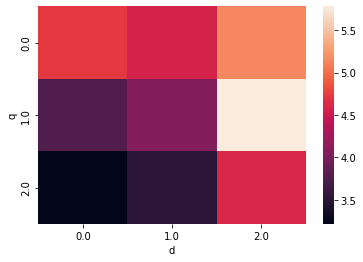

In [64]:
__ = df_result[['q','d','rmse']]
__ = __.groupby(['q','d'],as_index=False).mean()
_ = __.pivot('q','d','rmse')
sns.heatmap(_)

<AxesSubplot:xlabel='q', ylabel='p'>

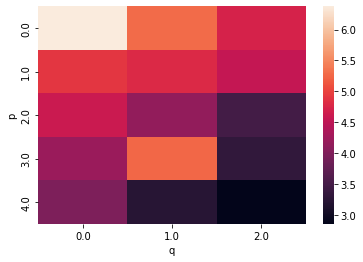

In [65]:
__ = df_result[['p','q','rmse']]
__ = __.groupby(['p','q'],as_index=False).mean()
_ = __.pivot('p','q','rmse')
sns.heatmap(_)

<AxesSubplot:xlabel='d', ylabel='p'>

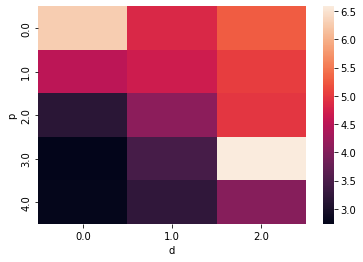

In [66]:
__ = df_result[['p','d','rmse']]
__ = __.groupby(['p','d'],as_index=False).mean()
_ = __.pivot('p','d','rmse')
sns.heatmap(_)